In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, float_model_acc, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
    
    if eval_metric == 'acc_drop':
        model_scores = (float_model_acc - model_scores) / float_model_acc
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / float_model_acc
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [4]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/DF_SVHN/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(-4, 7, 1)
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_10', 'conv2d_11', 
               'conv2d_16', 'conv2d_17', 'conv2d_19', 'conv2d_20'] + ['binary']
vmax=0.1

In [5]:
t_layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_12', 'conv2d_13', 'conv2d_16', 'conv2d_20', 'binary']

# SVHN

## Quantizing Weights

In [6]:
name = 'svhn_df'
model_path = 'svhn_df/svhn_df.h5'

from test_models.svhn_df import data
_, test_data = data.get_data()

df_svhn = model_data.Model(name, test_data, path=save_path + model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
float_model_acc = df_svhn.evaluate_accuracy()[1]

In [8]:
bw_range = np.arange(1, 3, 1)
f_range = np.arange(-4, 4, 1)
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_9', 'conv2d_10', 
               'conv2d_12', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'conv2d_19', 'conv2d_20', 
               'conv2d_22'] + ['binary']

In [9]:
s = brute_force_analysis_weights(df_svhn, layer_names, bw_range, f_range)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_5 done.


Layer conv2d_9 done.


Layer conv2d_10 done.


Layer conv2d_12 done.


Layer conv2d_15 done.


Layer conv2d_16 done.


Layer conv2d_17 done.


Layer conv2d_19 done.


Layer conv2d_20 done.


Layer conv2d_22 done.


Layer binary done.


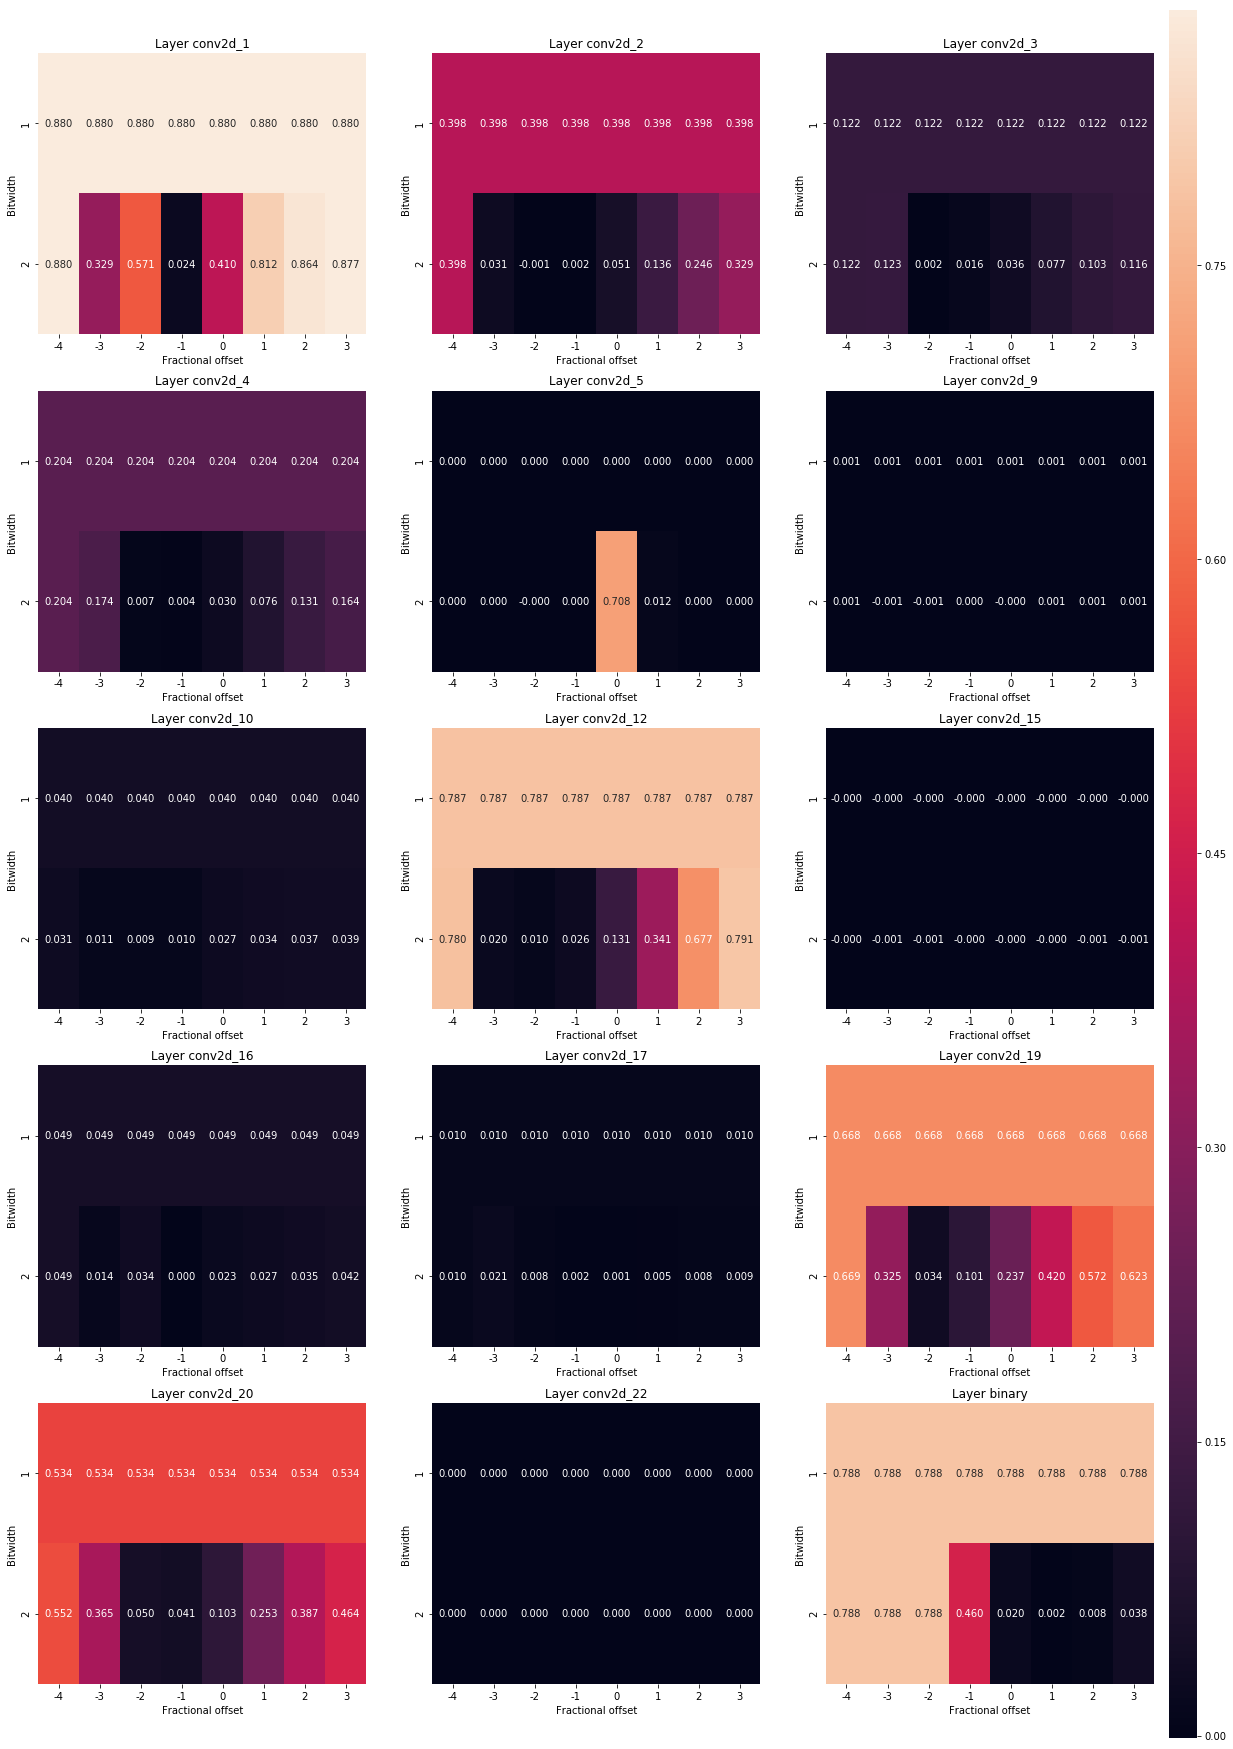

In [11]:
plot_results(s, layer_names, 5, 3, (20, 30), 0.8, bw_range, f_range)

In [8]:
bw_range = np.arange(1, 9, 1)
f_range = np.arange(-4, 7, 1)
t_layer_names_ = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_5', 'conv2d_10', 'conv2d_16', 'conv2d_19', 'binary']

In [23]:
scores_1 = brute_force_analysis_weights(df_svhn, t_layer_names_, bw_range, f_range, float_model_acc)
np.save(output_path + 'scores_1', arr=scores_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_5 done.


Layer conv2d_10 done.


Layer conv2d_16 done.


Layer conv2d_19 done.


Layer binary done.


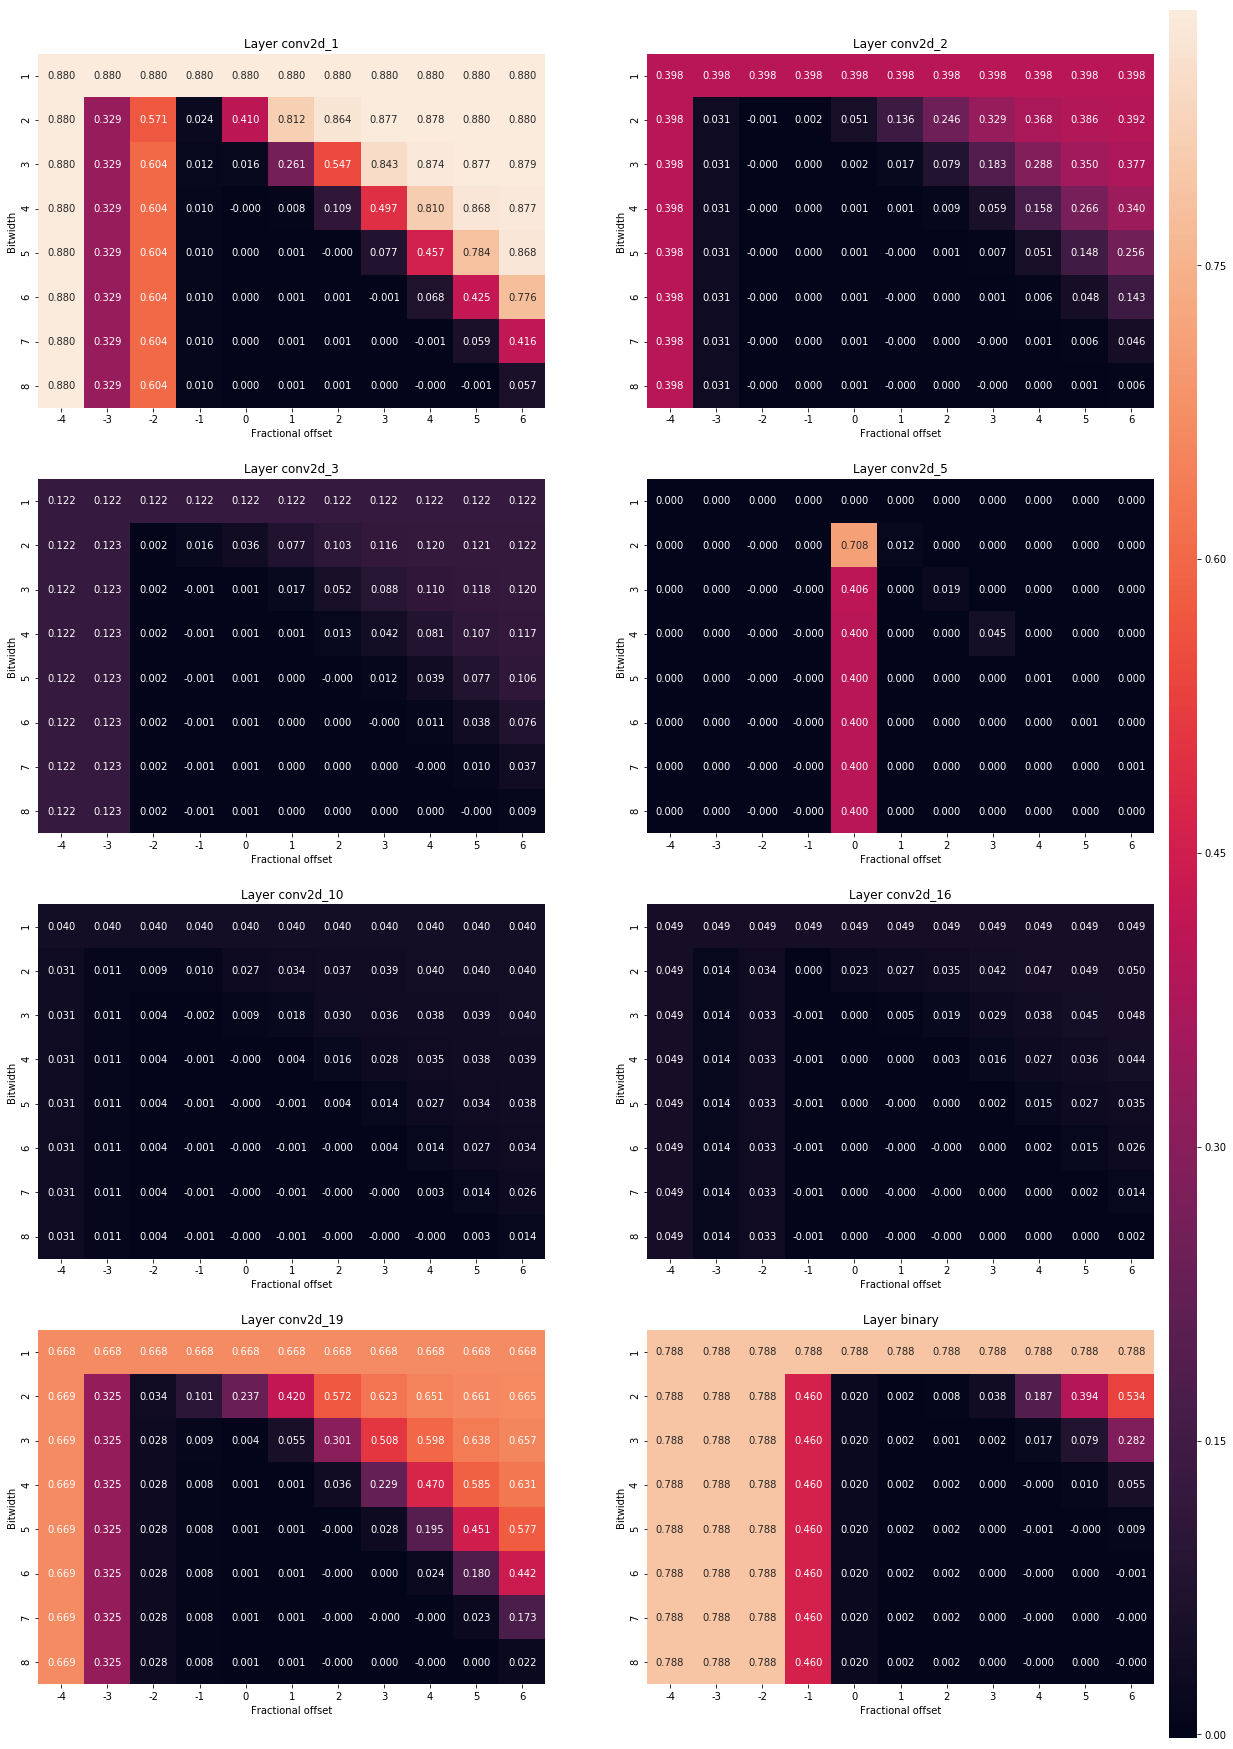

In [24]:
plot_results(scores_1, t_layer_names_, 4, 2, (20, 30), 0.8, bw_range, f_range)

In [26]:
t_layer_names_ = ['conv2d_6', 'conv2d_12', 'conv2d_16', 'conv2d_20']

In [27]:
scores_1_alt = brute_force_analysis_weights(df_svhn, t_layer_names_, bw_range, f_range, float_model_acc)
np.save(output_path + 'scores_1_alt', arr=scores_1_alt)

Layer conv2d_6 done.


Layer conv2d_12 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


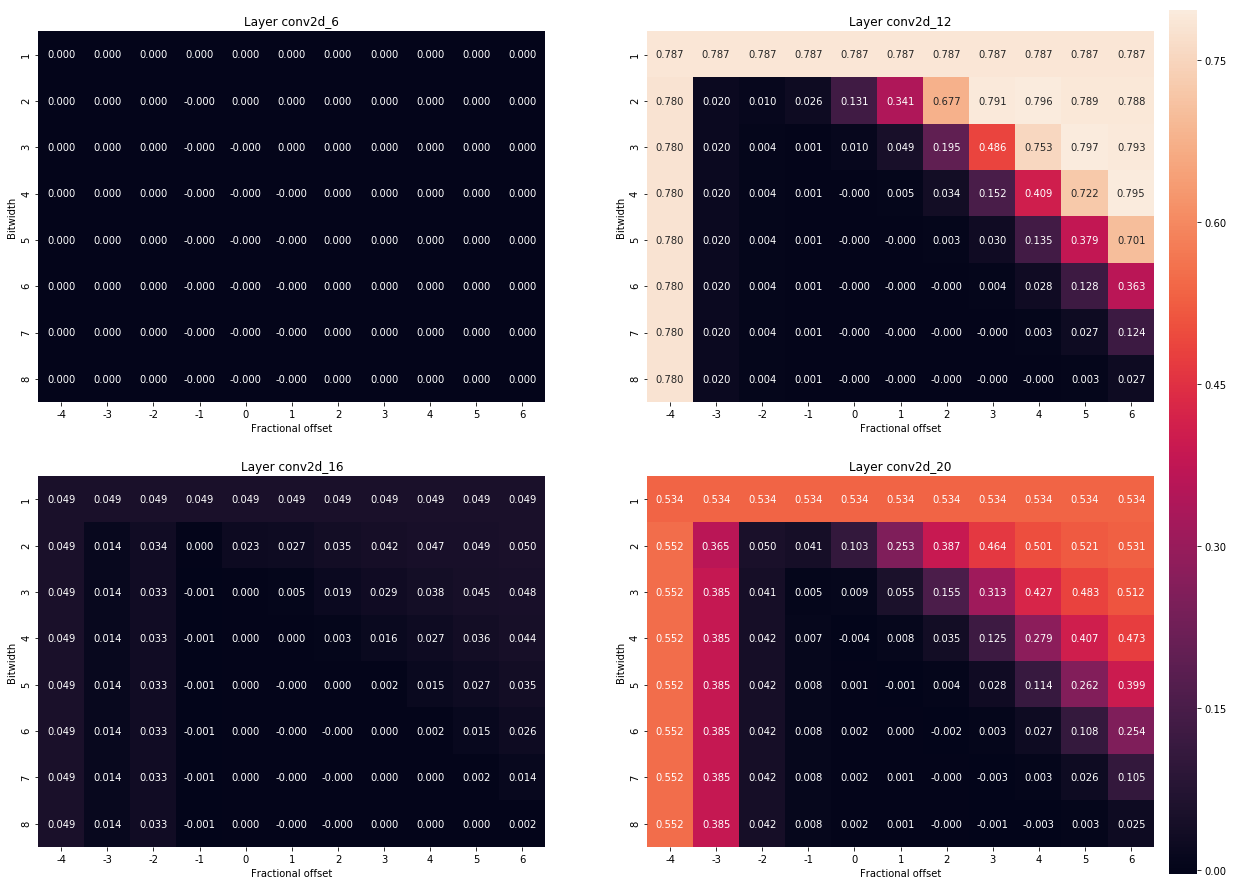

In [28]:
plot_results(scores_1_alt, t_layer_names_, 2, 2, (20, 15), 0.8, bw_range, f_range)

In [33]:
parameters = {
    'conv2d_1': [5, 0]
}
scores_2 = brute_force_analysis_weights(df_svhn, t_layer_names[1:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_2', arr=scores_2)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


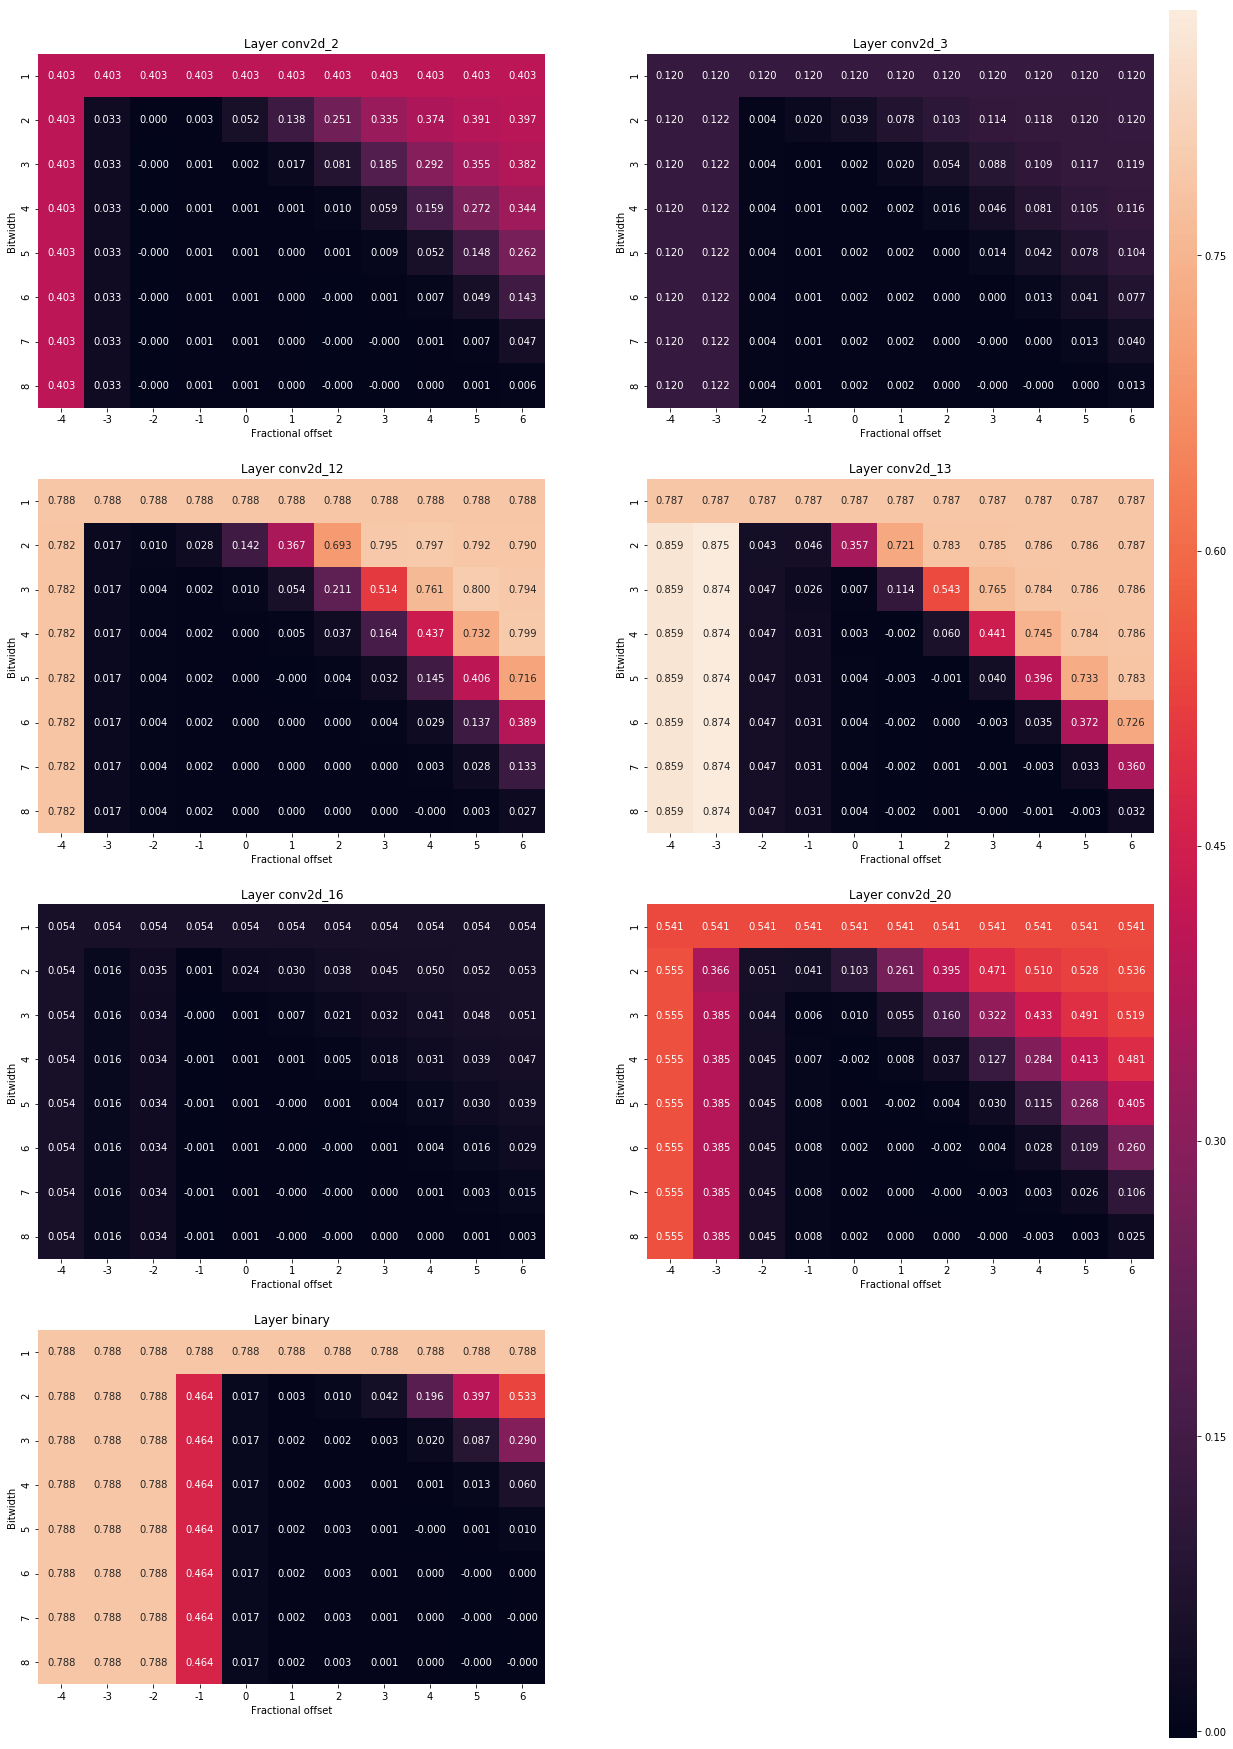

In [34]:
plot_results(scores_2, t_layer_names[1:], 4, 2, (20, 30), 0.8, bw_range, f_range)

In [35]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
}
scores_3 = brute_force_analysis_weights(df_svhn, t_layer_names[2:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_3', arr=scores_3)

Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


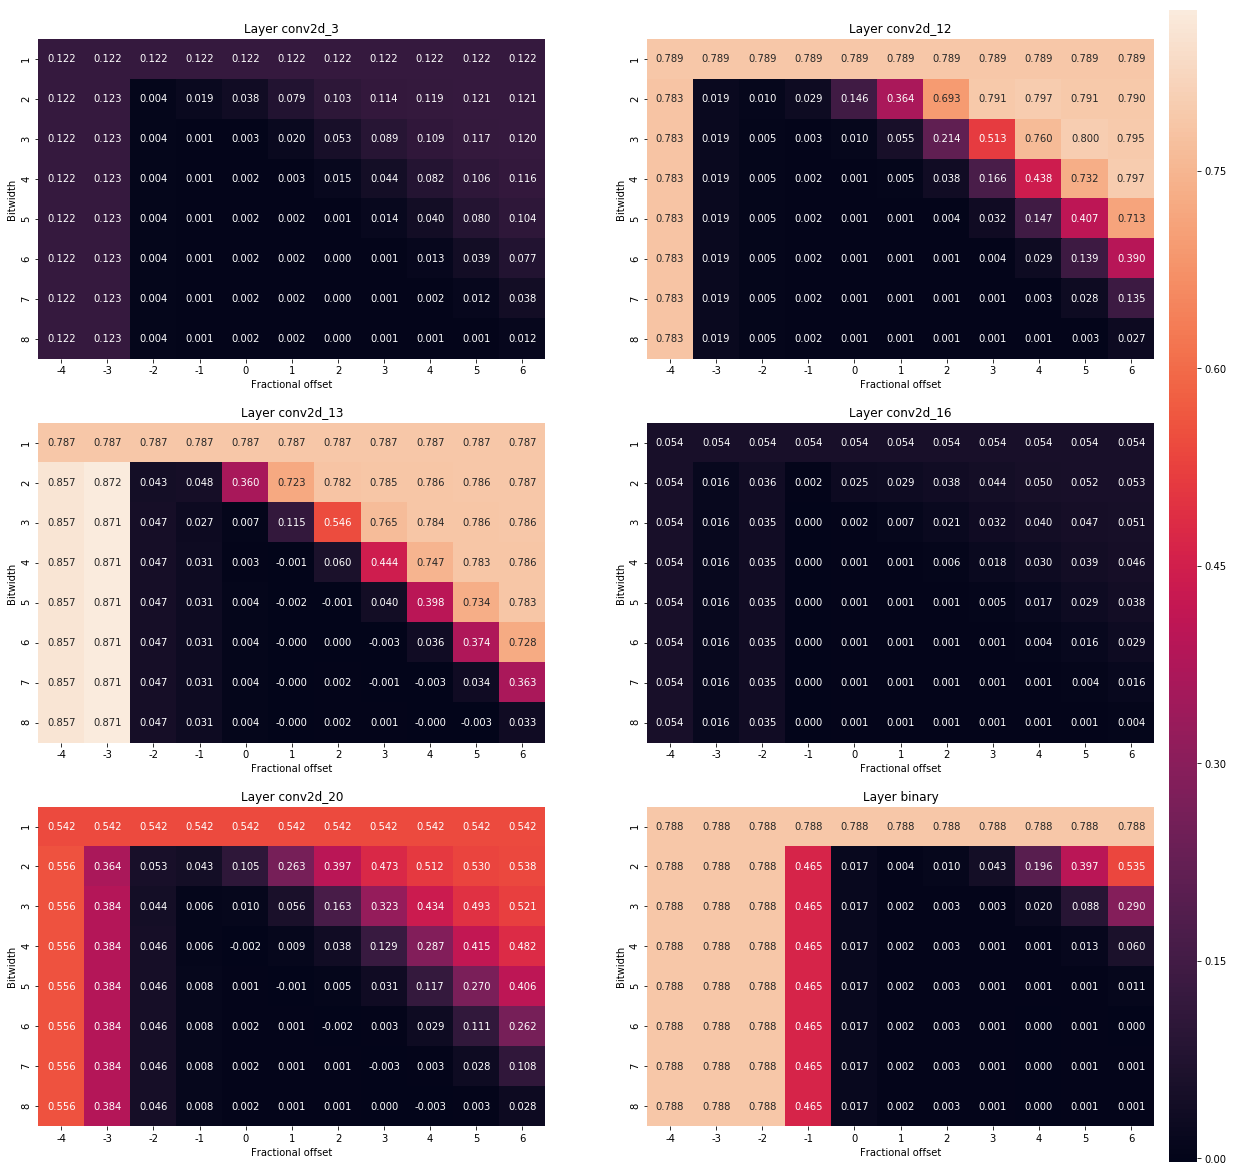

In [11]:
plot_results(scores_3, t_layer_names[2:], 3, 2, (20, 20), 0.8, bw_range, f_range)

In [12]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1]
}
scores_4 = brute_force_analysis_weights(df_svhn, t_layer_names[3:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_4', arr=scores_4)

Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


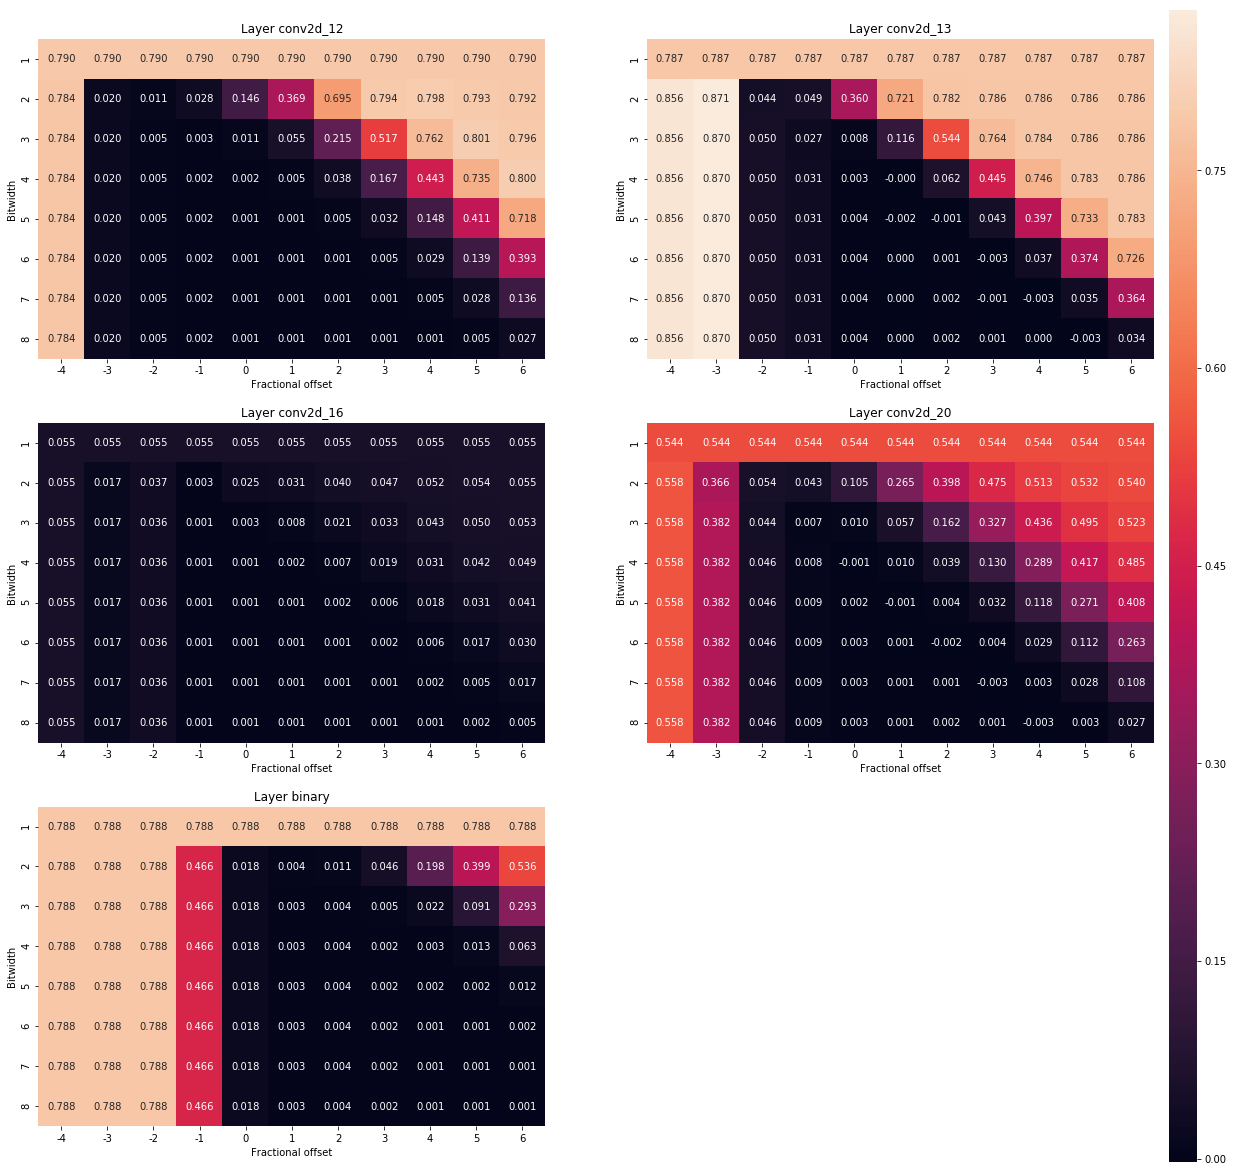

In [13]:
plot_results(scores_4, t_layer_names[3:], 3, 2, (20, 20), 0.8, bw_range, f_range)

In [15]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0]
}
scores_5 = brute_force_analysis_weights(df_svhn, t_layer_names[4:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_5', arr=scores_5)

Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


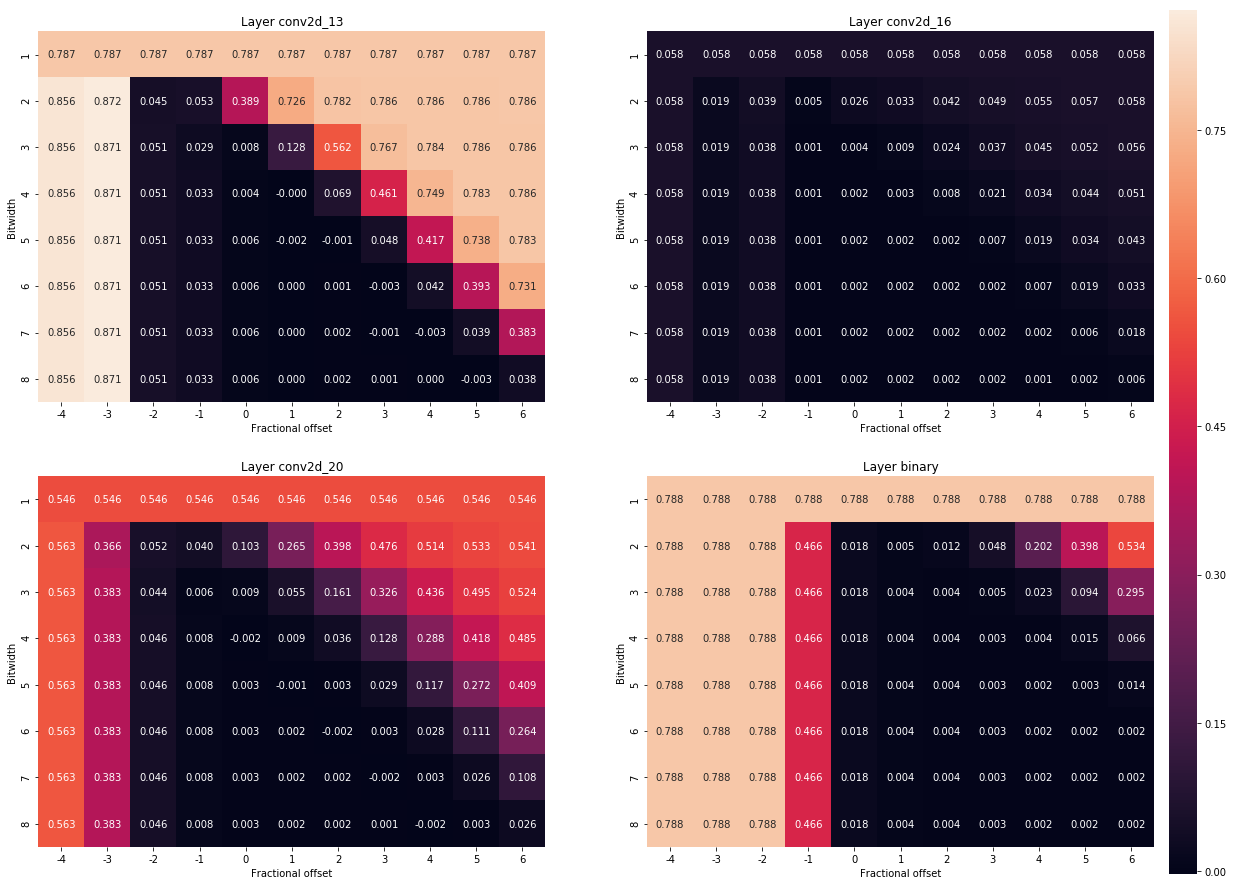

In [16]:
plot_results(scores_5, t_layer_names[4:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [17]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1]
}
scores_6 = brute_force_analysis_weights(df_svhn, t_layer_names[5:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_6', arr=scores_6)

Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


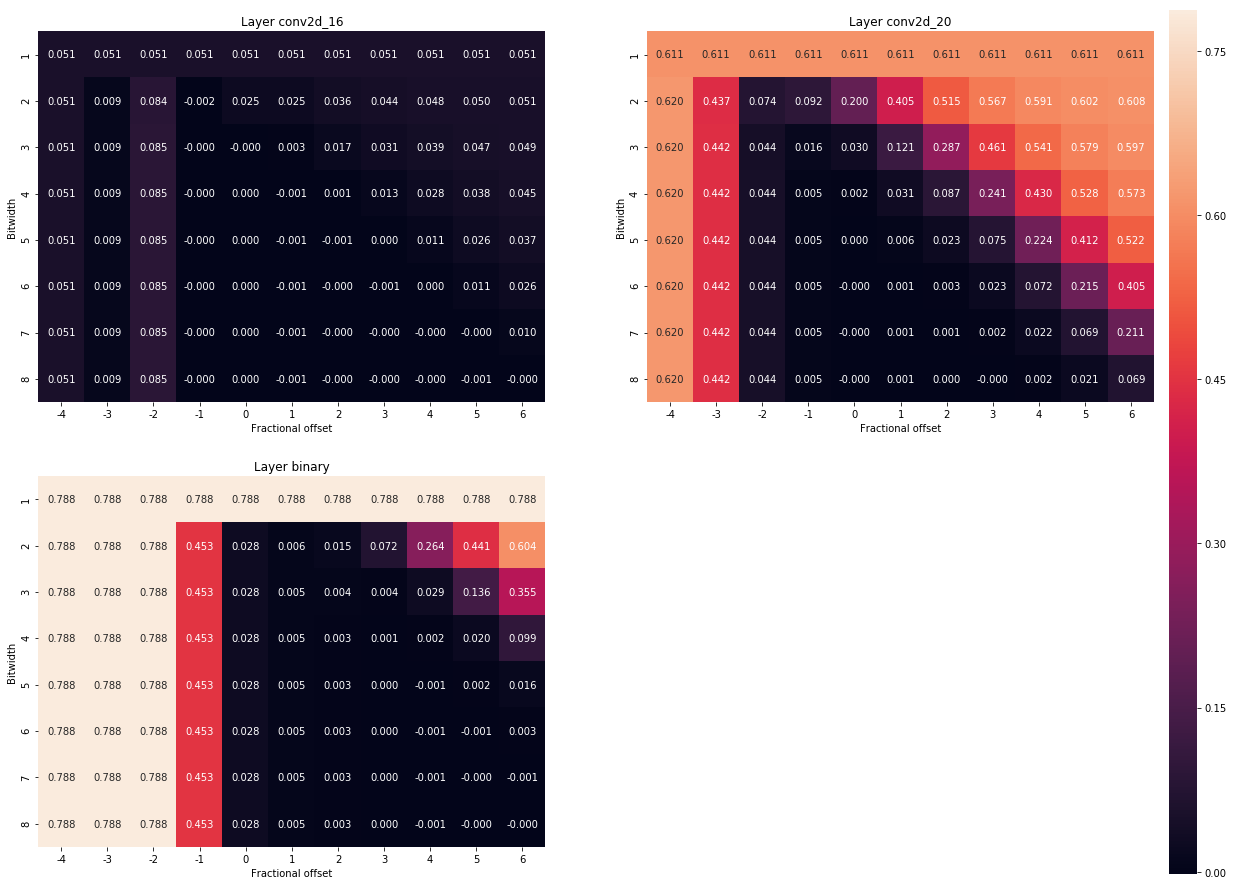

In [18]:
plot_results(scores_6, t_layer_names[5:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [19]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1]
}
scores_7 = brute_force_analysis_weights(df_svhn, t_layer_names[6:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_7', arr=scores_7)

Layer conv2d_20 done.


Layer binary done.


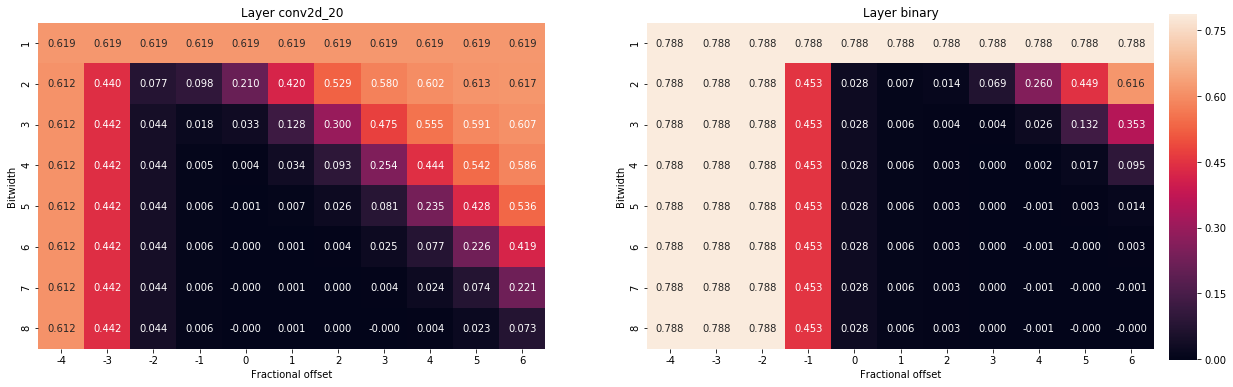

In [21]:
plot_results(scores_7, t_layer_names[6:], 1, 2, (20, 6), 0.8, bw_range, f_range)

In [24]:
parameters = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0]
}
scores_8 = brute_force_analysis_weights(df_svhn, t_layer_names[7:], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_8', arr=scores_8)

Layer binary done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


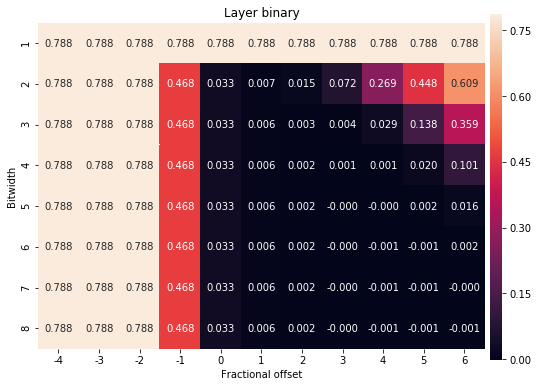

In [25]:
plot_results(scores_8, t_layer_names[7:], 1, 1, (8, 6), 0.8, bw_range, f_range)

In [9]:
parameters = {
    'conv2d_20': [5, 0],
    'binary': [4, 3]
}
scores_r1 = brute_force_analysis_weights(df_svhn, t_layer_names[:-2], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1', arr=scores_r1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


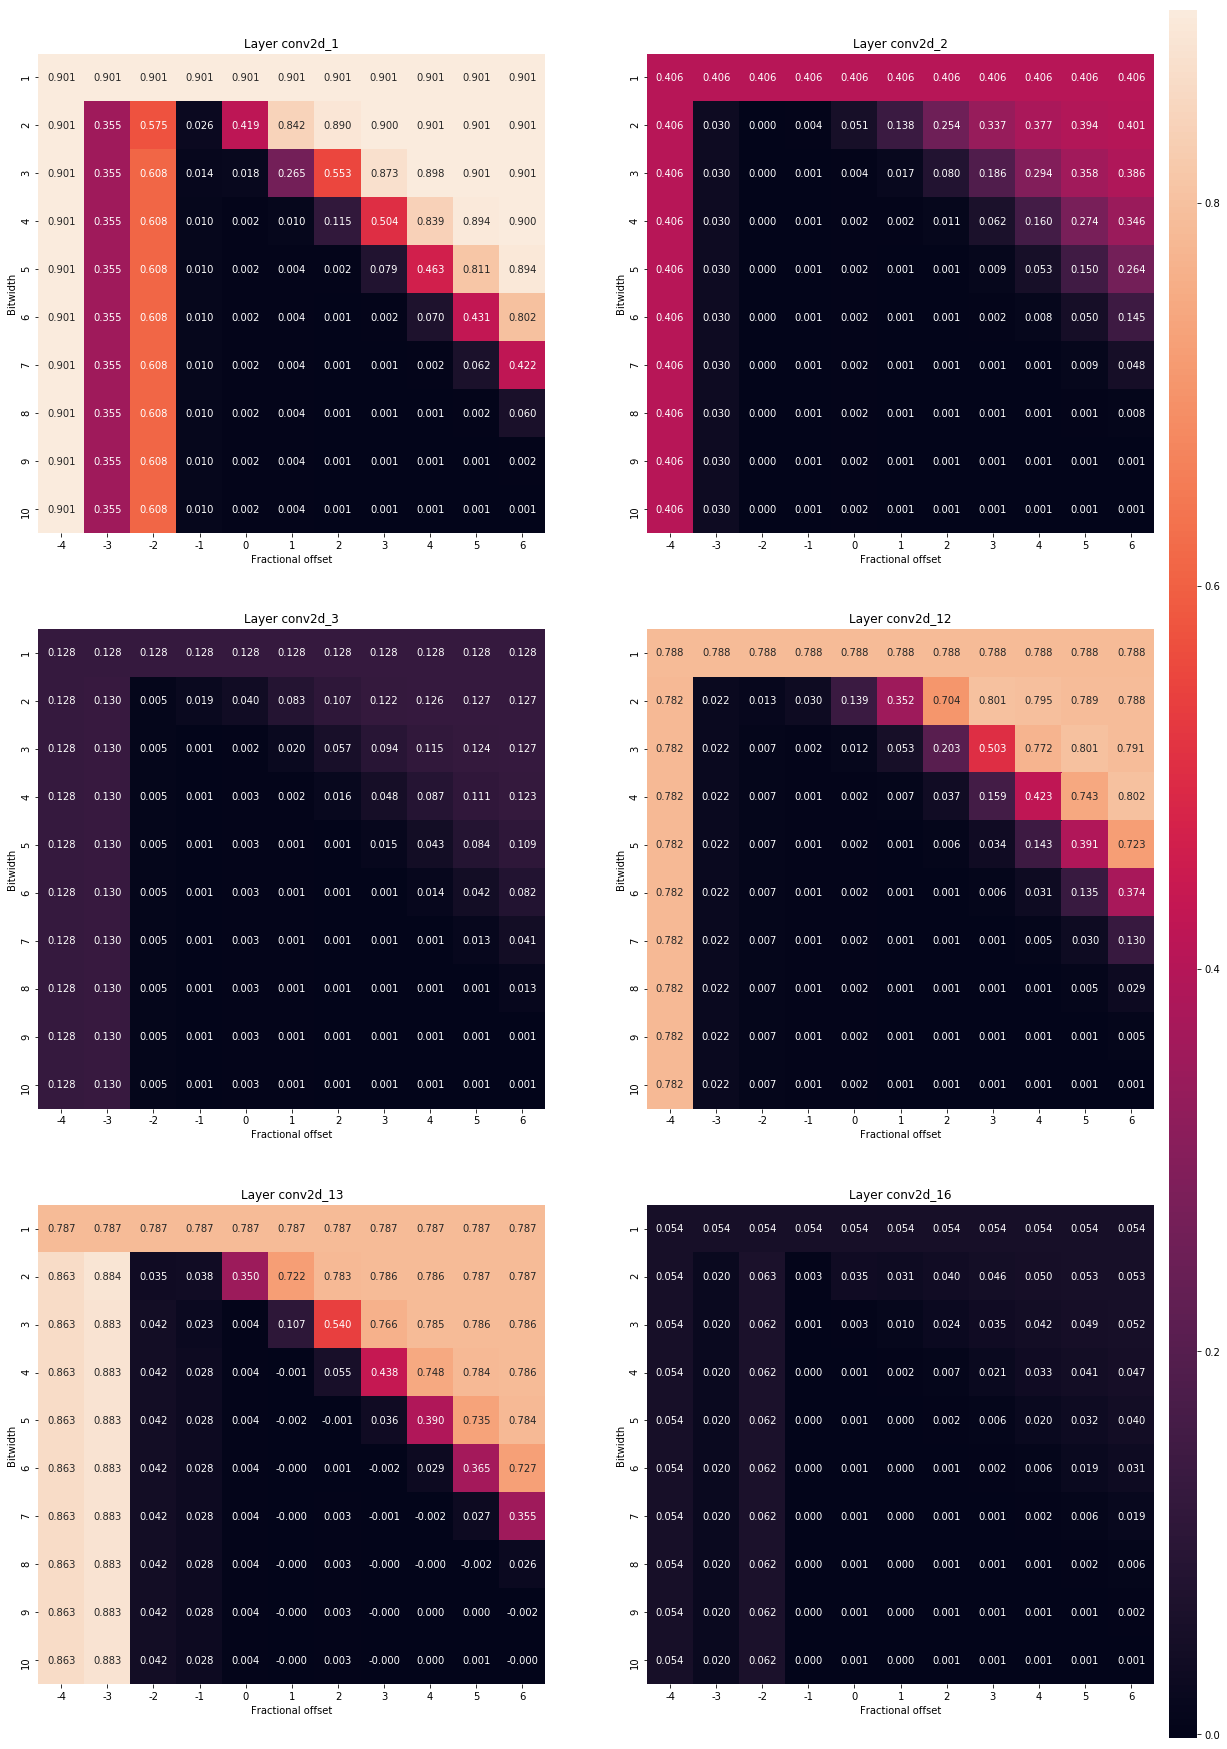

In [10]:
plot_results(scores_r1, t_layer_names[:-2], 3, 2, (20, 30), 0.8, bw_range, f_range)

In [11]:
parameters = {
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0],
    'binary': [4, 3]
}
scores_r2 = brute_force_analysis_weights(df_svhn, t_layer_names[:-3], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


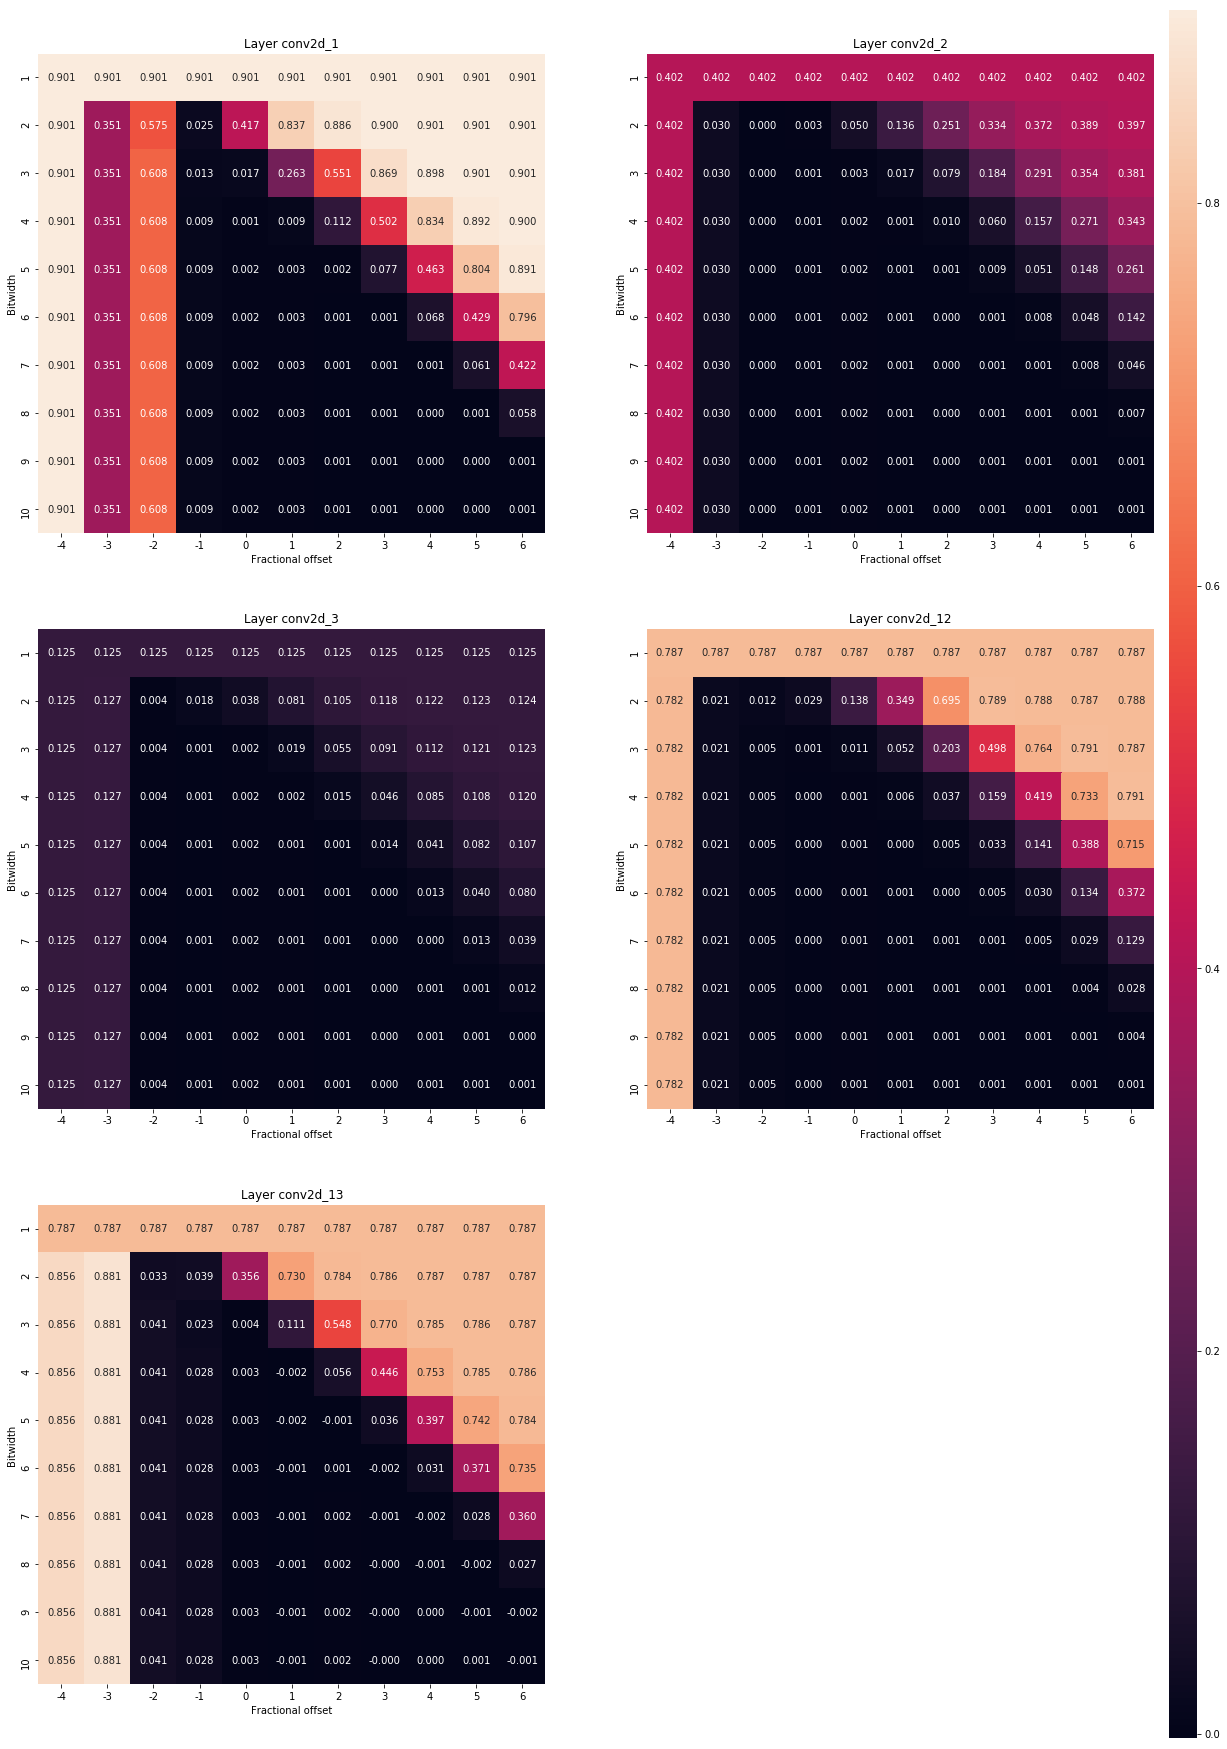

In [12]:
plot_results(scores_r2, t_layer_names[:-3], 3, 2, (20, 30), 0.8, bw_range, f_range)

In [13]:
parameters = {
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0],
    'binary': [4, 3]
}
scores_r3 = brute_force_analysis_weights(df_svhn, t_layer_names[:-4], bw_range, f_range, float_model_acc,
                                        fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


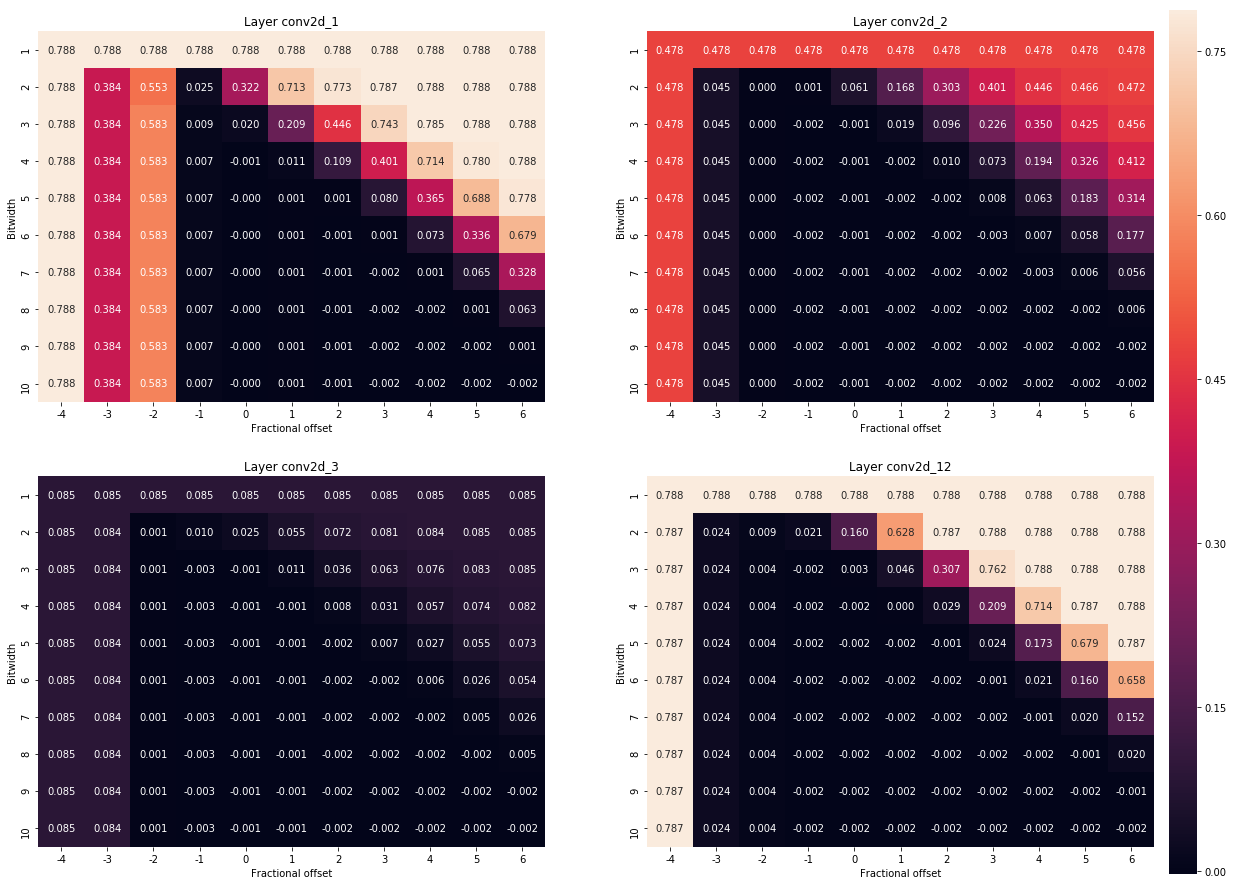

In [14]:
plot_results(scores_r3, t_layer_names[:-3], 2, 2, (20, 15), 0.8, bw_range, f_range)

## Quantizing biases

In [8]:
def fix_biases_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_biases(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model


def brute_force_analysis_biases(model, layer_names, bw_range, f_range, fix_w_quant=False, w_parameters=None,
                                fix_b_quant=False, b_parameters=None, eval_metric='acc_drop'):
    
    if (fix_w_quant and w_parameters is None) or (fix_b_quant and b_parameters is None):
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_w_quant:
                    model = fix_weights_quantization(model, w_parameters)
                    
                if fix_b_quant:
                    model = fix_biases_quantization(model, b_parameters)

                model.model = fxp_quantize.quantize_biases(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [10]:
w_quant_params = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0],
    'binary': [5, 3]
}
scores_b_1 = brute_force_analysis_biases(df_svhn, t_layer_names, bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params)
np.save(output_path + 'scores_b_1', arr=scores_b_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_12 done.


Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


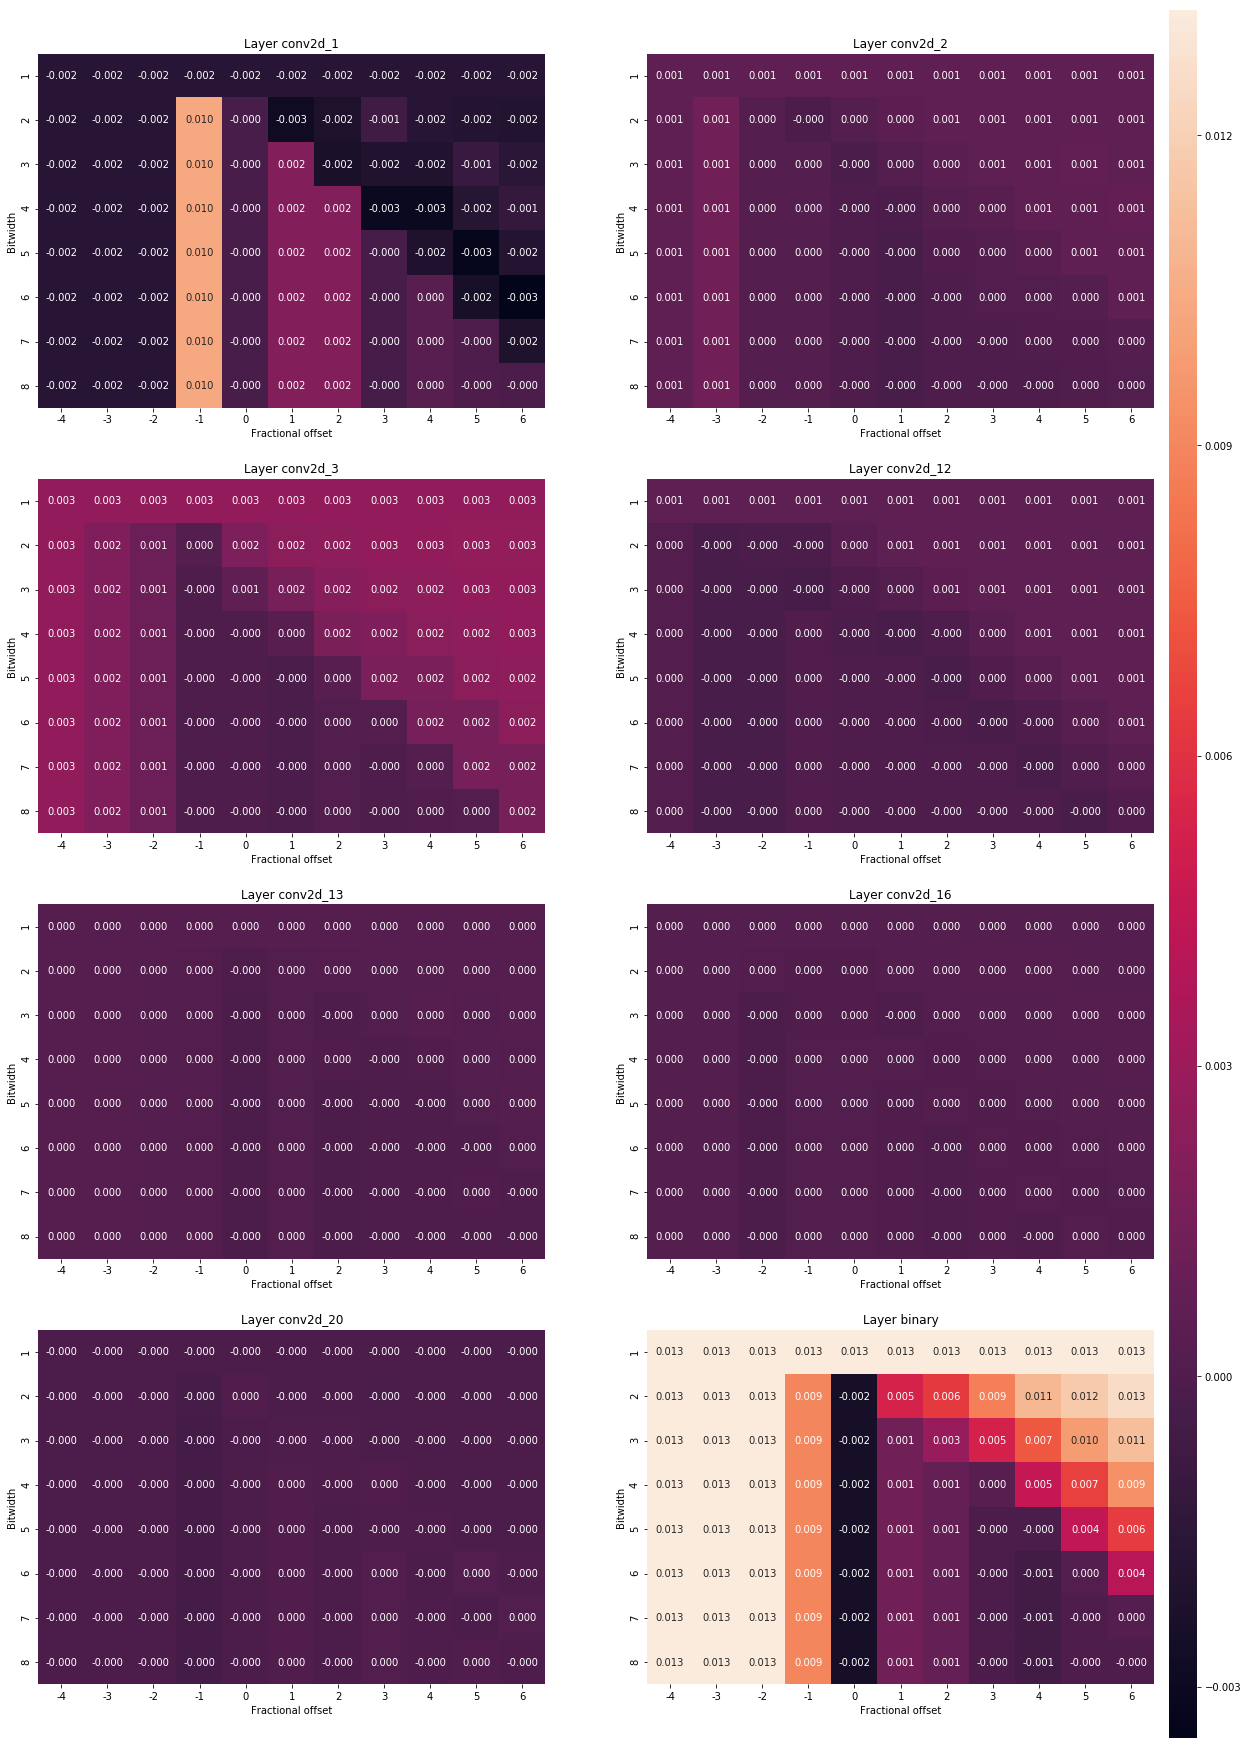

In [11]:
plot_results(scores_b_1, t_layer_names, 4, 2, (20, 30), 0.8, bw_range, f_range)

In [12]:
w_quant_params = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0],
    'binary': [5, 3]
}
b_quant_params = {
    'conv2d_1': [1, 0],
    'conv2d_2': [2, -1],
    'conv2d_3': [2, -1],
    'conv2d_12': [1, 0]
}
scores_b_2 = brute_force_analysis_biases(df_svhn, t_layer_names[4:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_2', arr=scores_b_2)

Layer conv2d_13 done.


Layer conv2d_16 done.


Layer conv2d_20 done.


Layer binary done.


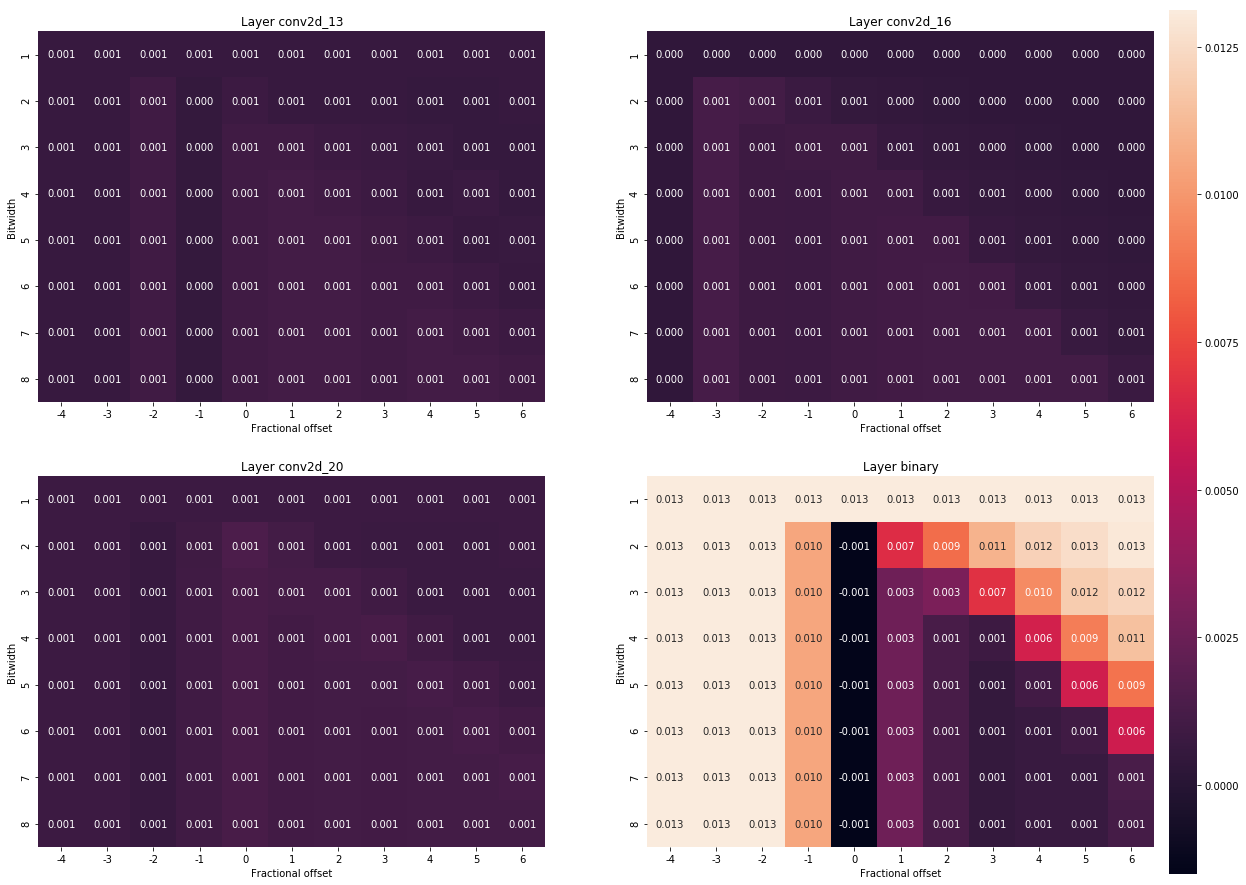

In [16]:
plot_results(scores_b_2, t_layer_names[4:], 2, 2, (20, 15), 0.8, bw_range, f_range)

In [9]:
w_quant_params = {
    'conv2d_1': [5, 0],
    'conv2d_2': [3, -1],
    'conv2d_3': [3, -1],
    'conv2d_12': [4, 0],
    'conv2d_13': [4, 1],
    'conv2d_16': [3, -1],
    'conv2d_20': [5, 0],
    'binary': [5, 3]
}
b_quant_params = {
    'conv2d_1': [1, 0],
    'conv2d_2': [2, -1],
    'conv2d_3': [2, -1],
    'conv2d_12': [1, 0],
    'conv2d_13': [1, 1],
    'conv2d_16': [1, 0],
    'conv2d_20': [1, 0],
}
scores_b_3 = brute_force_analysis_biases(df_svhn, t_layer_names[-1:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params, 
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_3', arr=scores_b_3)

Layer binary done.


C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


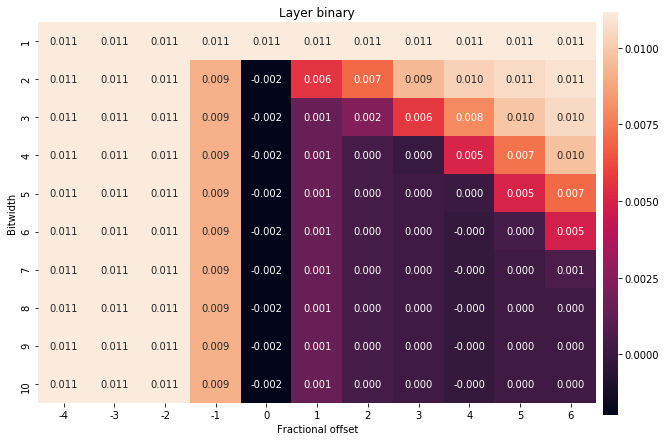

In [10]:
plot_results(scores_b_3, t_layer_names[-1:], 1, 1, (10, 7), 0.8, bw_range, f_range)